In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set professional plot style
sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)

print("Libraries imported successfully.")
print("Ready to analyze complete game mode structure!")


Libraries imported successfully.
Ready to analyze complete game mode structure!


In [2]:
# --- Database Connection Configuration ---
config = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'root',
    'database': 'spherych_devapp'
}

# --- Step 1: Understand WorkoutPresets (Game Modes) ---
print("=== STEP 1: ANALYZING WORKOUT PRESETS (GAME MODES) ===")

try:
    conn = mysql.connector.connect(**config)
    
    # Get all workout presets with their usage counts
    preset_query = """
    SELECT 
        wp.id,
        wp.name as game_mode,
        wp.exercisePool,
        COUNT(w.id) as workout_count
    FROM WorkoutPresets wp
    LEFT JOIN Workouts w ON wp.id = w.workoutPresetId
    WHERE w.completedWorkout = 1 AND w.score > 0
    GROUP BY wp.id, wp.name, wp.exercisePool
    ORDER BY workout_count DESC
    """
    
    presets_df = pd.read_sql(preset_query, conn)
    print("Workout Presets (Game Modes) with Usage Counts:")
    display(presets_df)
    
except Exception as e:
    print(f"Error: {e}")
finally:
    if 'conn' in locals() and conn.is_connected():
        conn.close()


=== STEP 1: ANALYZING WORKOUT PRESETS (GAME MODES) ===
Workout Presets (Game Modes) with Usage Counts:


,id,game_mode,exercisePool,workout_count
0,1,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,5780
1,2,UpperBody,touches;punches;jumps;burpees,2550
2,5,LeagueQualification,touches;punches;jumps;squats,2201
3,6,RehaFlow,touches;punches;jumps;squats;lunges,827
4,3,LegDay,touches;jumps;squats;lunges;tripples;burpees,78
5,4,HomeFlow,touches;punches;jumps;squats;lunges;tripples;b...,10


In [3]:
# --- Step 2: Analyze RaceConfigs (Difficulty & Duration Settings) ---
print("\n=== STEP 2: ANALYZING RACE CONFIGS (SETTINGS) ===")

try:
    conn = mysql.connector.connect(**config)
    
    # Get RaceConfigs distribution
    race_config_query = """
    SELECT 
        rc.difficulty,
        rc.duration,
        rc.startSpeed,
        COUNT(*) as config_count
    FROM RaceConfigs rc
    JOIN Workouts w ON rc.workoutId = w.id
    WHERE w.completedWorkout = 1 AND w.score > 0
    GROUP BY rc.difficulty, rc.duration, rc.startSpeed
    ORDER BY config_count DESC
    LIMIT 20
    """
    
    race_configs_df = pd.read_sql(race_config_query, conn)
    print("Top 20 RaceConfig Combinations (Difficulty + Duration + Start Speed):")
    display(race_configs_df)
    
except Exception as e:
    print(f"Error: {e}")
finally:
    if 'conn' in locals() and conn.is_connected():
        conn.close()



=== STEP 2: ANALYZING RACE CONFIGS (SETTINGS) ===
Top 20 RaceConfig Combinations (Difficulty + Duration + Start Speed):


,difficulty,duration,startSpeed,config_count
0,2,600.0,5,754
1,2,600.0,7,635
2,-1,600.0,5,576
3,2,300.0,5,436
4,-1,900.0,5,414
5,2,180.0,10,412
6,-1,300.0,5,370
7,2,600.0,10,324
8,2,180.0,5,321
9,2,300.0,10,318


In [4]:
# --- Step 3: Complete Dataset - Join Everything Together ---
print("\n=== STEP 3: CREATING COMPLETE DATASET ===")

try:
    conn = mysql.connector.connect(**config)
    
    # The comprehensive query that joins all relevant tables
    complete_query = """
    SELECT 
        w.id as workout_id,
        w.score,
        w.completedWorkout,
        w.measuredDuration as actual_duration,
        w.userId,
        
        -- Game Mode Information
        wp.name as game_mode,
        wp.exercisePool,
        
        -- Race Configuration
        rc.difficulty,
        rc.duration as planned_duration,
        rc.startSpeed,
        rc.hrTarget,
        
        -- User Demographics
        u.username,
        hd.dob,
        hd.weight,
        hd.height
        
    FROM Workouts w
    JOIN WorkoutPresets wp ON w.workoutPresetId = wp.id
    JOIN RaceConfigs rc ON w.id = rc.workoutId
    JOIN Users u ON w.userId = u.id
    LEFT JOIN HealthData hd ON u.id = hd.userId
    
    WHERE w.completedWorkout = 1 AND w.score > 0
    """
    
    df_complete = pd.read_sql(complete_query, conn)
    
    print(f"Complete dataset loaded: {len(df_complete)} records")
    print("\nFirst 5 rows of complete dataset:")
    display(df_complete.head())
    
except Exception as e:
    print(f"Error: {e}")
finally:
    if 'conn' in locals() and conn.is_connected():
        conn.close()



=== STEP 3: CREATING COMPLETE DATASET ===
Complete dataset loaded: 11448 records

First 5 rows of complete dataset:


,workout_id,score,completedWorkout,actual_duration,userId,game_mode,exercisePool,difficulty,planned_duration,startSpeed,hrTarget,username,dob,weight,height
0,2,480000,1,901.6750,3,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,2,900.0,6,0.9,Jules,1994-09-05,63.0,180.0
1,5,550,1,22.6134,5,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,2,600.0,5,0.9,Steff The Giant,1981-05-26,105.0,196.0
2,7,142015,1,304.2770,5,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,2,300.0,5,0.9,Steff The Giant,1981-05-26,105.0,196.0
3,9,257930,1,605.8880,4,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,2,600.0,5,0.9,Yanick,1997-03-05,80.0,186.0
4,10,12430,1,613.1410,7,DualFlow,touches;punches;jumps;squats;lunges;tripples;b...,2,600.0,5,0.9,Helen,1991-06-10,48.0,167.0


In [5]:
# --- Step 4: Feature Engineering & Data Preparation ---
print("\n=== STEP 4: FEATURE ENGINEERING ===")

if 'df_complete' in locals():
    # Calculate age from dob
    dob_datetime = pd.to_datetime(df_complete['dob'], errors='coerce')
    df_complete['age'] = (pd.to_datetime('today') - dob_datetime).dt.days / 365.25
    
    # Create age groups
    bins = [0, 18, 25, 35, 45, 55, 100]
    labels = ['<18', '18-25', '26-35', '36-45', '46-55', '55+']
    df_complete['age_group'] = pd.cut(df_complete['age'], bins=bins, labels=labels, right=False)
    
    # Convert duration from seconds to minutes for easier interpretation
    df_complete['duration_minutes'] = df_complete['planned_duration'] / 60
    
    print("Feature engineering completed.")
    print(f"Dataset shape: {df_complete.shape}")
    
    # Show summary statistics
    print("\nDataset Summary:")
    display(df_complete[['score', 'difficulty', 'duration_minutes', 'startSpeed', 'age']].describe())


=== STEP 4: FEATURE ENGINEERING ===
Feature engineering completed.
Dataset shape: (11448, 18)

Dataset Summary:


,score,difficulty,duration_minutes,startSpeed,age
count,1.144800e+04,11448.000000,11448.000000,11448.000000,9451.000000
mean,1.936351e+05,0.636705,9.572196,6.128931,44.932848
std,1.973387e+05,1.385635,6.047691,2.381418,14.566403
min,1.000000e+00,-1.000000,0.000000,0.000000,0.744695
25%,5.204125e+04,-1.000000,5.000000,5.000000,34.672142
50%,1.296430e+05,1.000000,10.000000,5.000000,44.106776
75%,2.833750e+05,2.000000,10.000000,8.000000,55.780972
max,1.395700e+06,2.000000,30.000000,10.000000,77.325120



=== STEP 5: GAME MODE ANALYSIS ===
Records per Game Mode:
game_mode
DualFlow               5780
UpperBody              2551
LeagueQualification    2202
RehaFlow                827
LegDay                   78
HomeFlow                 10
Name: count, dtype: int64


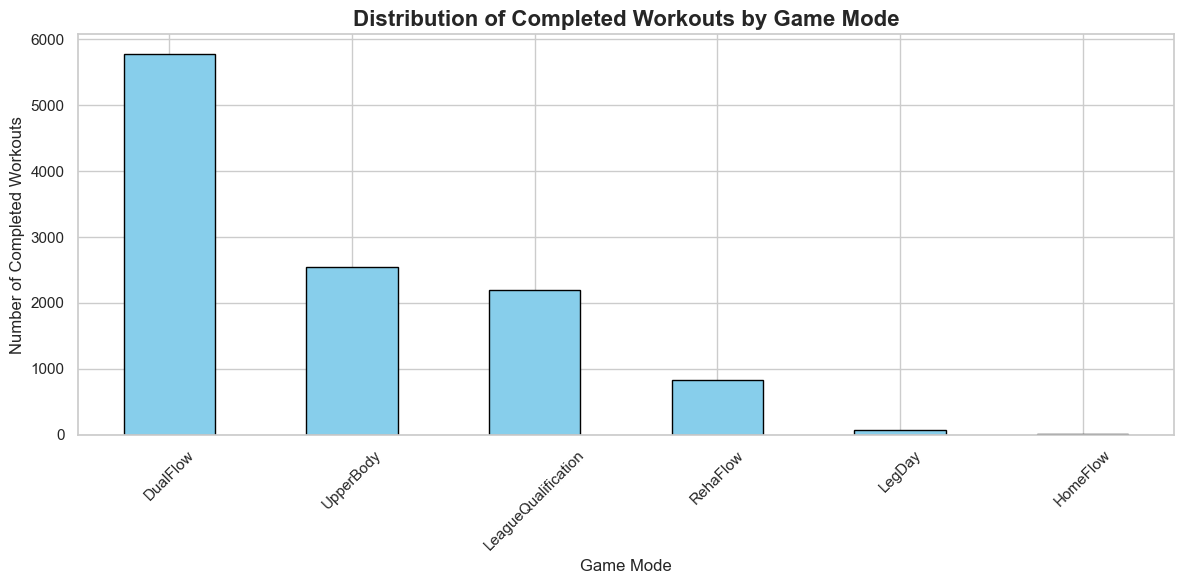


Score Statistics by Game Mode:


,count,mean,std,min,25%,50%,75%,max
game_mode,,,,,,,,
DualFlow,5780.0,195435.492734,205346.875225,50.0,54217.50,130346.0,266679.00,1163050.0
HomeFlow,10.0,51755.000000,95865.465599,450.0,2726.25,5797.5,54831.25,299830.0
LeagueQualification,2202.0,224004.645777,184931.168098,200.0,83350.00,171675.0,368925.00,1395700.0
LegDay,78.0,35725.602564,57166.378282,1.0,6445.25,14921.5,31398.75,276130.0
RehaFlow,827.0,232291.557437,165996.194066,300.0,95726.50,211195.0,334000.00,981050.0
UpperBody,2551.0,156193.551548,192725.472055,50.0,33950.00,81800.0,217250.00,1228050.0


In [6]:
# --- Step 5: Game Mode Distribution Analysis ---
print("\n=== STEP 5: GAME MODE ANALYSIS ===")

if 'df_complete' in locals():
    # Game mode distribution
    game_mode_counts = df_complete['game_mode'].value_counts()
    print("Records per Game Mode:")
    print(game_mode_counts)
    
    # Visualize game mode distribution
    plt.figure(figsize=(12, 6))
    game_mode_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Completed Workouts by Game Mode', fontsize=16, weight='bold')
    plt.xlabel('Game Mode')
    plt.ylabel('Number of Completed Workouts')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Show score statistics by game mode
    print("\nScore Statistics by Game Mode:")
    score_by_mode = df_complete.groupby('game_mode')['score'].describe()
    display(score_by_mode)

In [13]:
# --- Step 6: Find Best Difficulty + Duration + Game Mode Combinations ---
print("\n=== STEP 6: FINDING BEST COMBINATIONS FOR MODELING ===")

if 'df_complete' in locals():
    # Create combination analysis
    combination_analysis = df_complete.groupby(['game_mode', 'difficulty', 'duration_minutes']).agg({
        'workout_id': 'count',
        'score': ['mean', 'std', 'min', 'max'],
        'startSpeed': 'mean'
    }).round(2)
    
    combination_analysis.columns = ['workout_count', 'score_mean', 'score_std', 'score_min', 'score_max', 'avg_start_speed']
    combination_analysis = combination_analysis.reset_index()
    
    # Filter for combinations with at least 100 workouts (enough for robust modeling)
    viable_combinations = combination_analysis[combination_analysis['workout_count'] >= 100].sort_values('workout_count', ascending=False)
    
    # Show ALL viable combinations
    print("Viable Combinations for ML Modeling (≥100 workouts):")
    print(f"Showing all {len(viable_combinations)} viable combinations:")
    display(viable_combinations)
    
    print(f"\nTotal viable combinations: {len(viable_combinations)}")
    
    # Identify the BEST combination for first model
    if len(viable_combinations) > 0:
        best_combination = viable_combinations.iloc[0]
        print(f"\nRECOMMENDED COMBINATION FOR FIRST MODEL:")
        print(f"Game Mode: {best_combination['game_mode']}")
        print(f"Difficulty: {best_combination['difficulty']}")
        print(f"Duration: {best_combination['duration_minutes']} minutes")
        print(f"Sample Size: {best_combination['workout_count']} workouts")
        print(f"Average Score: {best_combination['score_mean']:,.0f}")
        print(f"Score Range: {best_combination['score_min']:,.0f} - {best_combination['score_max']:,.0f}")


=== STEP 6: FINDING BEST COMBINATIONS FOR MODELING ===
Viable Combinations for ML Modeling (≥100 workouts):
Showing all 34 viable combinations:


,game_mode,difficulty,duration_minutes,workout_count,score_mean,score_std,score_min,score_max,avg_start_speed
2,DualFlow,-1,10.0,945,144742.74,74946.03,150,318100,5.44
26,DualFlow,2,10.0,919,170480.24,102694.25,50,368400,6.23
43,LeagueQualification,2,10.0,774,317667.12,118113.35,900,456150,6.76
25,DualFlow,2,5.0,581,72085.29,50678.47,550,178110,6.51
1,DualFlow,-1,5.0,489,60032.74,37587.16,400,139450,5.93
3,DualFlow,-1,15.0,472,247628.36,114103.47,60,480700,5.44
24,DualFlow,2,3.0,431,48080.05,28060.69,172,97580,8.18
90,UpperBody,2,5.0,415,83994.22,50888.10,250,185400,6.16
35,LeagueQualification,-1,5.0,362,99309.67,62593.30,500,200550,4.92
27,DualFlow,2,15.0,352,367455.32,151185.00,308,577400,7.47



Total viable combinations: 34

RECOMMENDED COMBINATION FOR FIRST MODEL:
Game Mode: DualFlow
Difficulty: -1
Duration: 10.0 minutes
Sample Size: 945 workouts
Average Score: 144,743
Score Range: 150 - 318,100



=== STEP 7: PREPARING TARGET DATASET FOR MODELING ===
Target dataset for modeling: 945 records
Game Mode: DualFlow
Difficulty: -1
Duration: 10.0 minutes


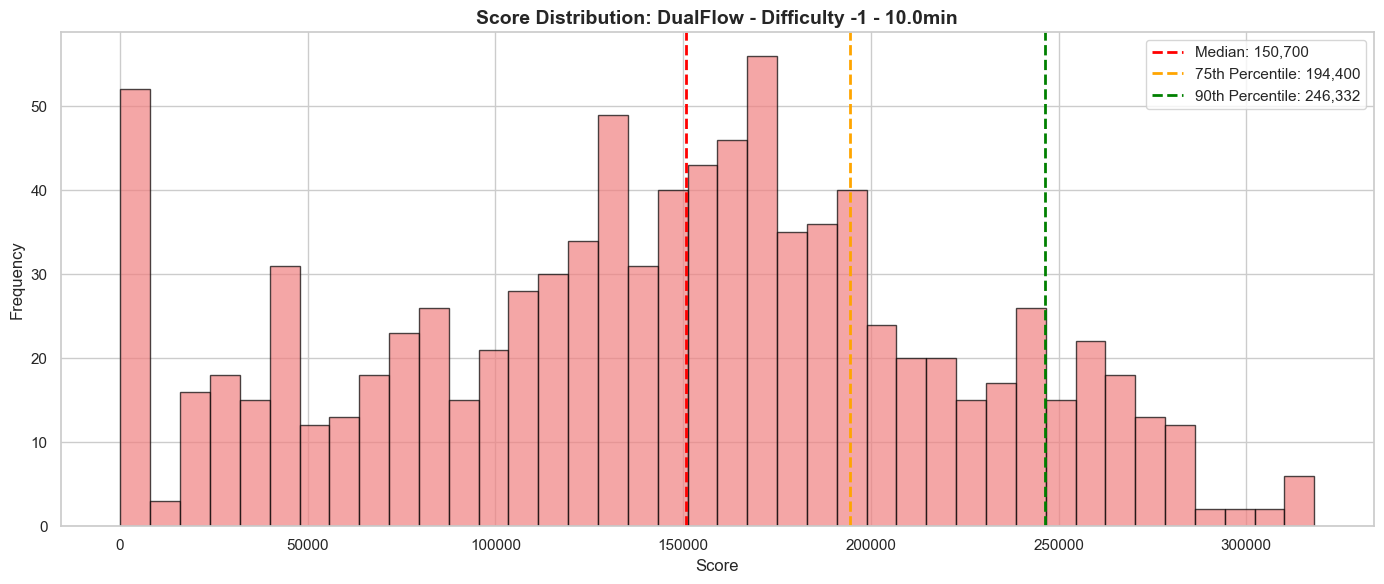


Target dataset ready for GMM training!
Next step: Train Gaussian Mixture Model on this 945-record dataset.
This will be the foundation of the motivational engine!


In [16]:
# --- Step 7: Extract and Visualize Target Dataset ---
print("\n=== STEP 7: PREPARING TARGET DATASET FOR MODELING ===")

if 'df_complete' in locals() and 'best_combination' in locals():
    # Filter for the best combination
    target_data = df_complete[
        (df_complete['game_mode'] == best_combination['game_mode']) &
        (df_complete['difficulty'] == best_combination['difficulty']) &
        (df_complete['duration_minutes'] == best_combination['duration_minutes'])
    ].copy()
    
    print(f"Target dataset for modeling: {len(target_data)} records")
    print(f"Game Mode: {best_combination['game_mode']}")
    print(f"Difficulty: {best_combination['difficulty']}")
    print(f"Duration: {best_combination['duration_minutes']} minutes")
    
    # Show score distribution for this specific combination
    plt.figure(figsize=(14, 6))
    plt.hist(target_data['score'], bins=40, alpha=0.7, edgecolor='black', color='lightcoral')
    plt.title(f'Score Distribution: {best_combination["game_mode"]} - Difficulty {best_combination["difficulty"]} - {best_combination["duration_minutes"]}min', 
              fontsize=14, weight='bold')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.axvline(target_data['score'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {target_data["score"].median():,.0f}')
    plt.axvline(target_data['score'].quantile(0.75), color='orange', linestyle='--', linewidth=2, label=f'75th Percentile: {target_data["score"].quantile(0.75):,.0f}')
    plt.axvline(target_data['score'].quantile(0.90), color='green', linestyle='--', linewidth=2, label=f'90th Percentile: {target_data["score"].quantile(0.90):,.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nTarget dataset ready for GMM training!")
    print(f"Next step: Train Gaussian Mixture Model on this {len(target_data)}-record dataset.")
    print(f"This will be the foundation of the motivational engine!")